In [1]:
import lightgbm as lgb
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import numpy as np

In [3]:
train = pd.read_pickle('./data/mean_train.pkl')
test = pd.read_pickle('./data/mean_test.pkl')

In [4]:
with open('./data/' "y.pkl", 'rb') as pickle_file:
    y = pickle.load(pickle_file)

In [5]:
print(len(train), len(y))final_data = lgb.Dataset(data=train, label=y, categorical_feature=categorical_features, free_raw_data=False)

4357544 4357544


In [6]:
zeros = 0
for x in y:
    if x == 0:
        zeros += 1
print(zeros/len(y))

0.0852154332807655


In [7]:
X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.2)

In [8]:
X_train.dtypes

Ticket number            float64
Issue Date                 int64
Issue time               float64
Meter Id                 float64
Marked Time              float64
RP State Plate           float64
Plate Expiry Date        float64
VIN                      float64
Body Style               float64
Color                    float64
Location                 float64
Route                    float64
Agency                   float64
Violation code           float64
Violation Description    float64
Fine amount              float64
Latitude                 float64
Longitude                float64
crime_clusters             int32
total_clusters             int32
Issue_time               float64
dtype: object

In [9]:
categorical_features = ['Issue Date', 'crime_clusters', 'total_clusters']
train_data = lgb.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
test_data = lgb.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

In [20]:
#best parameters so far
params = {
    'is_unbalance': True,
    'objective': 'binary',
    'boosting': 'DART',
    'learning_rate': 0.55,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 1e-4,
    'num_iterations': 5000,
    'num_leaves': 24,
    'max_depth': 60,
    'num_threads': -1,
    'reg_alpha': 100, # L1 regularization
    'reg_lambda': 50, # L2 regularization
    'bagging_fraction': 0.8,
    'bagging_frequency': 0.7,
    'subsample': 0.8, # subsample ratio of the training instance
    'feature_fraction_bynode': 0.8,
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.8, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1e-3, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 50,# minimum number of data needed in a leaf
    'metrics': ['auc', 'binary_logloss'],
    'pred_contrib': False
}

In [15]:
#trial run
params = {
    'is_unbalance': True,
    'objective': 'binary',
    'boosting': 'DART',
    'learning_rate': 0.01,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 1e-4,
    'num_iterations': 5000,
    'num_leaves': 24,
    'max_depth': -1,
    'num_threads': -1,
    'reg_alpha': 100, # L1 regularization
    'reg_lambda': 50, # L2 regularization
    'bagging_fraction': 0.8,
    'bagging_frequency': 0.7,
    'subsample': 0.8, # subsample ratio of the training instance
    'feature_fraction_bynode': 0.8,
    'colsample_bytree': 0.8, # subsample ratio of columns when constructing the tree
    'min_split_gain': 0.6, # minimum loss reduction required to make further partition on a leaf node of the tree
    'min_child_weight': 1e-3, # minimum sum of instance weight (hessian) needed in a leaf
    'min_child_samples': 50,# minimum number of data needed in a leaf
    'metrics': ['auc', 'binary_logloss'],
    'pred_contrib': False
}

In [21]:
class ModelExtractionCallback(object):
    """Callback class for retrieving trained model from lightgbm.cv()
    NOTE: This class depends on '_CVBooster' which is hidden class, so it might doesn't work if the specification is changed.
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # Saving _CVBooster object.
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # Throw exception if the callback class is not called.
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # return Booster object
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # return list of Booster
        return self._model.boosters
  
    @property
    def best_iteration(self):
        self._assert_called_cb()
        # return boosting round when early stopping.
        return self._model.best_iteration

In [22]:
extraction_cb = ModelExtractionCallback()
eval_metrics = lgb.cv(params,train_set = train_data, early_stopping_rounds=100, callbacks=[extraction_cb])

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [23]:
proxy = extraction_cb.boosters_proxy
pickle.dump( proxy, open( "proxy.pkl", "wb" ) )
boosters = extraction_cb.raw_boosters
pickle.dump( boosters, open( "boosters.pkl", "wb" ) )
best_iteration = extraction_cb.best_iteration
pickle.dump( best_iteration, open( "proxy.pkl", "wb" ) )

In [24]:
for i, booster in enumerate(boosters                                                                                ):
    y_pred_proba = booster.predict(X_test,
                                   num_iteration=best_iteration)
    print(y_pred_proba)
    #y_pred = np.argmax(y_pred_proba, axis=1)
    y_max = []
    for x in y_pred_proba:
        if x > 0.5:
            y_max.append(1)
        else:
            y_max.append(0)
    accuracy = accuracy_score(y_test, y_max)
    cm = confusion_matrix(y_test, y_max)
    report = classification_report(y_test,y_max)
    auc = roc_auc_score(y_test, y_max)
  #  log = log_loss(y_test, y_max)
    print('Model {0} accuracy: {1}'.format(i, accuracy))
    print('Model {0} auc: {1}'.format(i,auc))
    print(cm)
    print(report)

[0.52170169 0.38099628 0.98992297 ... 0.98878484 0.41484179 0.59997936]
Model 0 accuracy: 0.7427748881537655
Model 0 auc: 0.7554804589955575
[[ 57124  16987]
 [207187 590211]]
              precision    recall  f1-score   support

           0       0.22      0.77      0.34     74111
           1       0.97      0.74      0.84    797398

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.59    871509
weighted avg       0.91      0.74      0.80    871509

[0.43579583 0.39122712 0.98808921 ... 0.9859399  0.42740958 0.67095617]
Model 1 accuracy: 0.7388449230013688
Model 1 auc: 0.7561907008588398
[[ 57591  16520]
 [211079 586319]]
              precision    recall  f1-score   support

           0       0.21      0.78      0.34     74111
           1       0.97      0.74      0.84    797398

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.59    871509
weighted avg       0.91      0.74      0.79    87

In [25]:
evaluation = pd.DataFrame.from_dict(eval_metrics)
pickle.dump( evaluation, open( "eval_dart.pkl", "wb" ) )
len(evaluation)

61

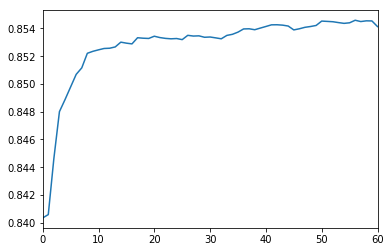

In [26]:
evaluation['auc-mean'].plot(kind='line')

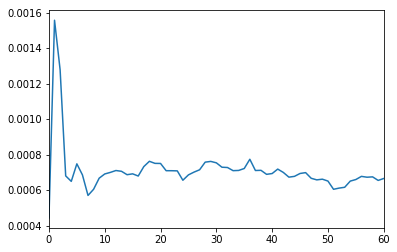

In [27]:
evaluation['auc-stdv'].plot(kind='line')

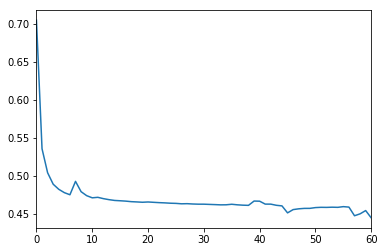

In [28]:
evaluation['binary_logloss-mean'].plot(kind='line')

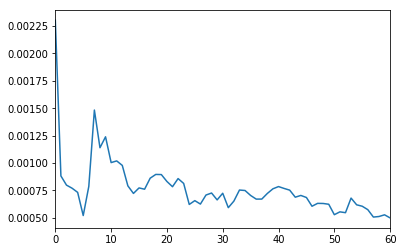

In [29]:
evaluation['binary_logloss-stdv'].plot(kind='line')

In [227]:
pickle.dump( params, open( "params.pkl", "wb" ) )

In [34]:
test = lgb.train(params, train_set = train_data, valid_sets = test_data, early_stopping_rounds=100, evals_result = eval_metrics)

[1]	valid_0's binary_logloss: 0.706635	valid_0's auc: 0.83982
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.536505	valid_0's auc: 0.841108
[3]	valid_0's binary_logloss: 0.504383	valid_0's auc: 0.844618
[4]	valid_0's binary_logloss: 0.489473	valid_0's auc: 0.847468
[5]	valid_0's binary_logloss: 0.482631	valid_0's auc: 0.848272
[6]	valid_0's binary_logloss: 0.478162	valid_0's auc: 0.849351
[7]	valid_0's binary_logloss: 0.475369	valid_0's auc: 0.850325
[8]	valid_0's binary_logloss: 0.492833	valid_0's auc: 0.850689
[9]	valid_0's binary_logloss: 0.479083	valid_0's auc: 0.851877
[10]	valid_0's binary_logloss: 0.474632	valid_0's auc: 0.851926
[11]	valid_0's binary_logloss: 0.471795	valid_0's auc: 0.852108
[12]	valid_0's binary_logloss: 0.4725	valid_0's auc: 0.852087
[13]	valid_0's binary_logloss: 0.470896	valid_0's auc: 0.852136
[14]	valid_0's binary_logloss: 0.469222	valid_0's auc: 0.852425
[15]	valid_0's binary_logloss: 0.467888	valid_0's auc

In [35]:
preds = test.predict(X_test)

In [36]:
y_max = []
for x in preds:
    if x > 0.5:
        y_max.append(1)
    else:
        y_max.append(0)
accuracy = accuracy_score(y_test, y_max)
cm = confusion_matrix(y_test, y_max)
report = classification_report(y_test,y_max)
auc = roc_auc_score(y_test, y_max)
print('Model {0} accuracy: {1}'.format(i, accuracy))
print('Model {0} auc: {1}'.format(i,auc))
print(cm)
print(report)

Model 4 accuracy: 0.7358753610117623
Model 4 auc: 0.7561039417094108
[[ 57842  16269]
 [213918 583480]]
              precision    recall  f1-score   support

           0       0.21      0.78      0.33     74111
           1       0.97      0.73      0.84    797398

    accuracy                           0.74    871509
   macro avg       0.59      0.76      0.58    871509
weighted avg       0.91      0.74      0.79    871509



In [ ]:
test.save_model("final.txt")

In [ ]:
bst = lgb.Booster(model_file='final.txt')

In [1]:
!gsutil cp final.txt gs://kaggle-days-sf

Copying file://final.txt [Content-Type=text/plain]...
- [1 files][258.1 KiB/258.1 KiB]                                                
Operation completed over 1 objects/258.1 KiB.                                    
